In [1]:
using Plots, LinearAlgebra, Statistics, SparseArrays, Arpack, FFTW, DeltaRCWA

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278
┌ Info: Precompiling Arpack [7d9fca2a-8960-54d3-9f78-7d1dccf2cb97]
└ @ Base loading.jl:1278
┌ Info: Precompiling FFTW [7a1cc6ca-52ef-59f5-83cd-3a7055c09341]
└ @ Base loading.jl:1278
┌ Info: Precompiling deltaRCWA [64a8dc3d-f8fa-4cac-a309-acce05caa2e9]
└ @ Base loading.jl:1278


# Stage by Stage

**Input Data**

Two layers with thickness d, size L.
Assume Gaussian function delta layer
z = 0 at the top of layer 1, x = 0 on the left of each cell

In [2]:
L = 1 # width of cell [arb]
λ₀ = 1.2 # incoming light wavelength [units of L]
ω₀ = 2*pi/λ₀

ϵ₁ = 1 # air in the first layer
d₁ = 2 # thickness of first layer [units of L]
ϵ₂ = 1 # air in the second layer
d₂ = 2 # thickness of second layer [units of L]

delta(n) = n == 0
f0(x, z) = @. 1+ 5*delta(x-x) * delta(z-d₁) # constant surface dielectric
f1(x, z) = @. 1+ exp(-(x-L/2)^2/(2*L^2/16)) * delta(z-d₁) # gaussian function in x

nvec = 0:99 # 100 modes

0:99

In [3]:
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 

100-element Frequencies{Float64}:
   0.0
   6.283185307179586
  12.566370614359172
  18.84955592153876
  25.132741228718345
  31.41592653589793
  37.69911184307752
  43.982297150257104
  50.26548245743669
  56.548667764616276
  62.83185307179586
  69.11503837897544
  75.39822368615503
   ⋮
 -75.39822368615503
 -69.11503837897544
 -62.83185307179586
 -56.548667764616276
 -50.26548245743669
 -43.982297150257104
 -37.69911184307752
 -31.41592653589793
 -25.132741228718345
 -18.84955592153876
 -12.566370614359172
  -6.283185307179586

┌ Info: Precompiling GR_jll [d2c73de3-f751-5644-a686-071e5b155ba9]
└ @ Base loading.jl:1278


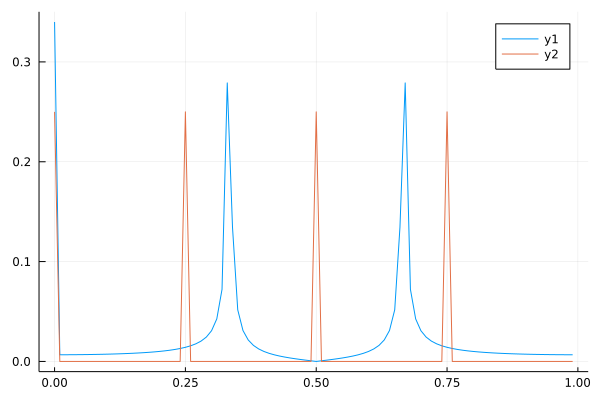

In [4]:
#### initial wave
xvec = range(0, L, length=length(nvec)+1)[1:length(nvec),]

u_p = [mod(n, 3) == 0 ? 1 : 0 for n in nvec] # all even modes set to 1, p is the positive side
u_n = [mod(n, 4) == 0 ? 1 : 0 for n in nvec] # all multiples of 3 set to 1, n is the negative side

E_in_p = ifft(u_p)
E_in_n = ifft(u_n)

plot(xvec, abs.(E_in_p))
plot!(xvec, abs.(E_in_n))



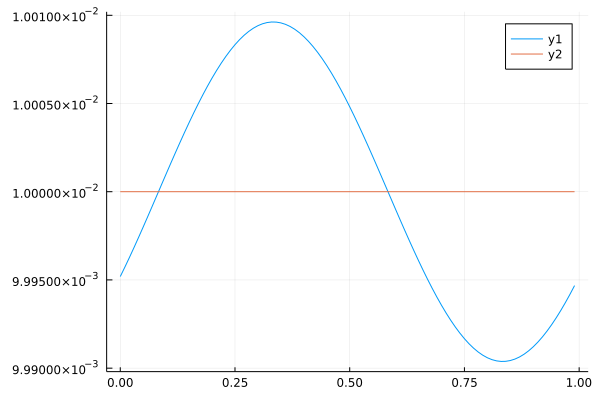

In [5]:
#### propagate through first layer. (right before boundary)
β₁ = @. sqrt(Complex(ω₀^2*ϵ₁ - kₓ^2)) # propagation constant in first layer
β₂ = @. sqrt(Complex(ω₀^2*ϵ₂ - kₓ^2)) # propagation constant in second layer

u_p = u_p .* exp.(1im*β₁*d₁)
u_n = u_n .* exp.(1im*β₂*d₂)

E_in_p = ifft(u_p)
E_in_n = ifft(u_n)

plot(xvec, abs.(E_in_p))
plot!(xvec, abs.(E_in_n))

In [6]:
#### Scattering matrix (one mode)
k = ω₀
βₙ = @. sqrt(Complex(ω₀^2*ϵ₁ - kₓ^2))


M = Matrix(Diagonal(repeat([1], length(nvec))*1im))
N = Matrix(Diagonal(repeat([6], length(nvec))*1im))

A = [-Diagonal(βₙ)-k*M -Diagonal(βₙ)-k*M; -Diagonal(βₙ)-k*N Diagonal(βₙ)+k*N]
B = [-Diagonal(βₙ)+k*M -Diagonal(βₙ)+k*M; Diagonal(βₙ)+k*N -Diagonal(βₙ)-k*N]

S = A\B


200×200 Array{Complex{Float64},2}:
 -0.5-0.5im        0.0+0.0im  …        0.0+0.0im        0.0+0.0im
  0.0+0.0im  -0.601205+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im  …        0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im  …        0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
  0.0+0.0im        0.0+0.0im           0.0+0.0im        0.0+0.0im
     ⋮                        ⋱                   
  0.0+0.0im        0.0+0.0im           0.0+0.0im        

In [7]:
ip = [findall(isreal, βₙ); findall(isreal, βₙ).+length(βₙ)]
Sp = S[ip,ip]

2×2 Array{Complex{Float64},2}:
 -0.5-0.5im   0.5-0.5im
  0.5-0.5im  -0.5-0.5im

In [8]:
norm(Sp'Sp-I)/norm(Sp'Sp)

1.9229626863835638e-16

In [9]:
norm(S'S-I)/norm(S'S)

0.21997483440189752

In [10]:
#### Scattering matrix (all modes)
k = w0
# M = Matrix(Diagonal(rand(length(nvec))*1im))
# N = Matrix(Diagonal(rand(length(nvec))*1im))
M = Matrix(Diagonal(repeat([1], length(nvec))*1im))
N = Matrix(Diagonal(repeat([6], length(nvec))*1im))
A = [-Diagonal(β₁)-k*ifft(fft(M, 2), 1)    -Diagonal(β₁)-k*ifft(fft(M, 2), 1);
    -Diagonal(β₁)-k*ifft(fft(N, 2), 1)     Diagonal(β₁)+k*ifft(fft(N, 2), 1)]
B = [Diagonal(β₁)+k*ifft(fft(M, 2), 1)    Diagonal(β₁)+k*ifft(fft(M, 2), 1);
    Diagonal(β₁)+k*ifft(fft(N, 2), 1)      -Diagonal(β₁)-k*ifft(fft(N, 2), 1)]

#     A = [-2*Diagonal(β)-k*ifft(fft(M+N, 2), 1)    -k*ifft(fft(M-N, 2), 1);
#         -k*ifft(fft(N-M, 2), 1)                   2*Diagonal(β)+k*ifft(fft(N+M, 2), 1)]
#     B = [-2*Diagonal(β)+k*ifft(fft(M+N, 2), 1)    k*ifft(fft(M-N, 2), 1);
#         k*ifft(fft(N-M, 2), 1)                  2*Diagonal(β)-k*ifft(fft(N+M, 2), 1)]

S = A\B


LoadError: [91mUndefVarError: w0 not defined[39m

In [11]:
norm(S'S-I)/norm(S'S)

0.21997483440189752

In [12]:
nvec = 0:99
M = Matrix(Diagonal(repeat([2], length(nvec))*1im))
N = Matrix(Diagonal(repeat([0.5], length(nvec))*1im))

# M = Matrix(Diagonal(rand(length(nvec))*10im))
# N = Matrix(Diagonal(rand(length(nvec))*1im))

# M = Matrix(Diagonal([(n > 45 && n < 75) ? 1 : 0 for n in nvec])*10im)
# N = Matrix(Diagonal([(n > 45 && n < 75) ? 1 : 0 for n in nvec])*10im)

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# plot(abs.(u_p), label="region 1")
# display(plot!(abs.(u_n), label="region 2"))

λ_vec = 0.25:1e-2:2
N_vec = 0.5:0.1:2
T = zeros(0)
for λi in λ_vec
#     N = Matrix(Diagonal(repeat([Ni], length(nvec))*1im))
    Ti, phasei = get_transmissivity_normalincident(M, N, 1, λi, u_p, u_n)
    append!(T, Ti)
end

LoadError: [91mUndefVarError: fftfreq not defined[39m

In [13]:
plot(λ_vec, T, ylim=(-0.1, 1.1))

BoundsError: [91mBoundsError: attempt to access 0-element Array{Float64,1} at index [1:176][39m

In [14]:
nvec = 0:2
M = Matrix(Diagonal(repeat([1], length(nvec))*0im))
N = 4*M

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

S, β = get_all_modes(M, N, 1, 0.5)
u_in = [u_p; u_n]
u_out = S*u_in
display(β)
# display(S)
display(u_in)
display(u_out)

LoadError: [91mUndefVarError: fftfreq not defined[39m

# Debugging

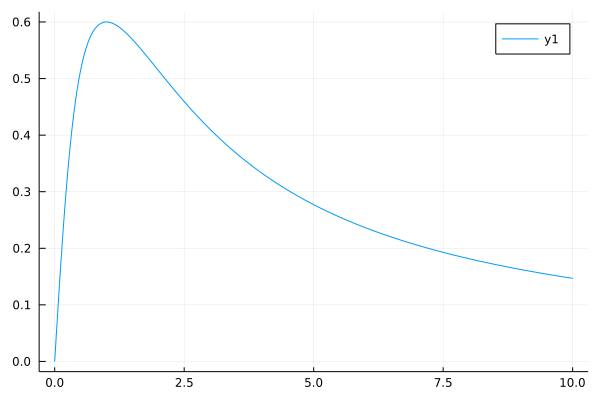

In [15]:
#### trying to debug (5/6/21)
nvec = 0:3
λ = 0.25
L = 1

Y_vec = 0:0.01:10
T = zeros(0)
for Yi in Y_vec
    Y = Matrix(Diagonal(repeat([1], length(nvec))*Yi*(1im)))
    # Y = Matrix(Diagonal([0; 1; 2; 3; 2; 1; 0])*1im)

    u_p = [n == 0 ? 1 : 0 for n in nvec]
    u_n = [n == 0 ? 0 : 0 for n in nvec]

    ω₀ = 2*pi/λ
    k = ω₀
    nvec = 0:length(Y)^0.5-1 # 100 modes
    kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
    β = @. sqrt(Complex(ω₀^2 - kₓ^2))
    # display(β)

    A = [Diagonal(β)+0.5*k*ifft(fft(Y, 2), 1)    Diagonal(β)+0.5*k*ifft(fft(Y, 2), 1);
        Diagonal(β)+2*k*ifft(fft(Y, 2), 1)     -Diagonal(β)-2*k*ifft(fft(Y, 2), 1)]
    B = [Diagonal(β)-0.5*k*ifft(fft(Y, 2), 1)    Diagonal(β)-0.5*k*ifft(fft(Y, 2), 1);
        Diagonal(β)-2*k*ifft(fft(Y, 2), 1)      -Diagonal(β)+2*k*ifft(fft(Y, 2), 1)]

    S = A\B
    # display(S)

    u_in = [u_p; u_n]
    u_out = S*u_in

    append!(T, abs(u_out[5]))
#     println(abs(u_out[5])^2 + abs(u_out[1])^2)
end

plot(Y_vec, T)

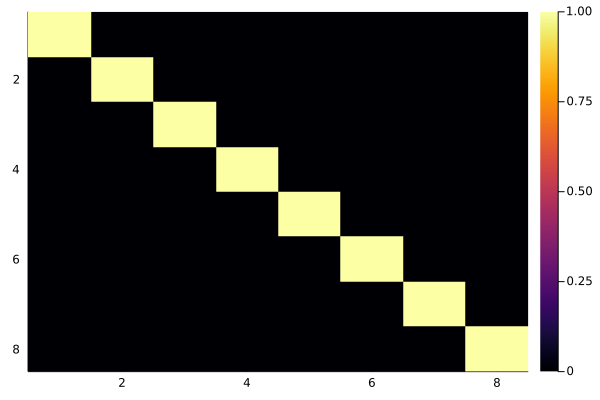

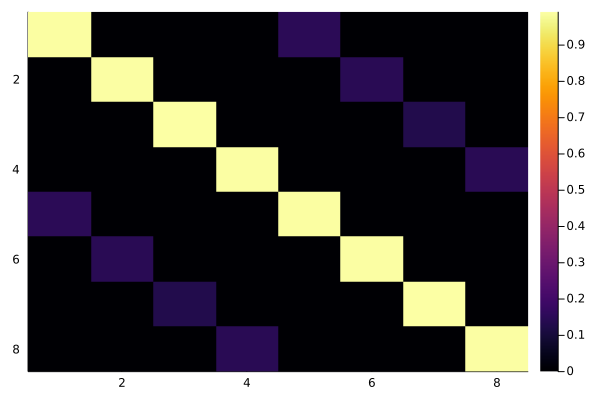

2.3399567996595153e-16

In [16]:
print(norm(S'S-I)/norm(S'S))
display(heatmap(abs.(S'S), yflip=true))
display(heatmap(abs.(S), yflip=true))

In [17]:
nvec = 0:3
M = Matrix(Diagonal(repeat([0.1], length(nvec))*1im))
N = Matrix(Diagonal(repeat([100], length(nvec))*1im))

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λ = 0.75
ω₀ = 2*pi/λ
k = ω₀
nvec = 0:length(M)^0.5-1 # 100 modes
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
β = @. sqrt(Complex(ω₀^2 - kₓ^2))
# display(β)

A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
    -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
    -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
S = A\B
# display(S)

u_in = [u_p; u_n]
u_out = S*u_in
display(u_in)
display(u_out)
println("reflection: ", abs(u_out[1])^2)
println("transmission: ", abs(u_out[5])^2)
println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2)

8-element Array{Int64,1}:
 1
 0
 0
 0
 0
 0
 0
 0

8-element Array{Complex{Float64},1}:
 -0.00980100009801018 - 0.109008901090089im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im
   0.9899990198999901 - 0.08901090089010899im
                  0.0 + 0.0im
                  0.0 + 0.0im
                  0.0 + 0.0im

reflection: 0.011979000119790001
transmission: 0.9880209998802097
energy: 0.9999999999999998


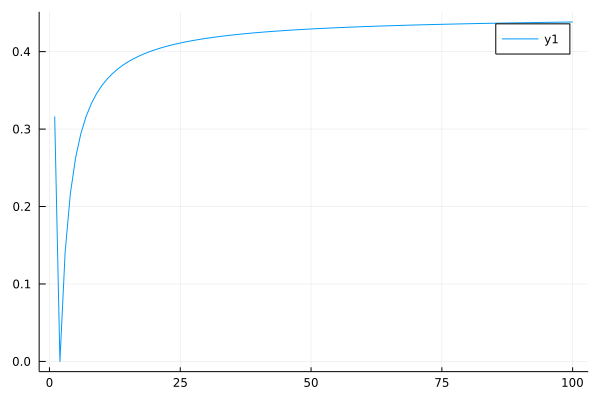

In [18]:
nvec = 0:3
M = Matrix(Diagonal(repeat([2], length(nvec))*1im))
N = Matrix(Diagonal(repeat([2], length(nvec))*1im))

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λ = 0.75
ω₀ = 2*pi/λ
k = ω₀
nvec = 0:length(M)^0.5-1 # 100 modes
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
β = @. sqrt(Complex(ω₀^2 - kₓ^2))
# display(β)

T = zeros(0)
Nvec = 1:1:100
for Ni in Nvec
    N = Matrix(Diagonal(repeat([Ni], length(nvec))*1im))
    A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
        -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
    B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
        -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
    S = A\B
    # display(S)

    u_in = [u_p; u_n]
    u_out = S*u_in
#     display(u_in)
#     display(u_out)
#     println("reflection: ", abs(u_out[1]))
#     println("transmission: ", abs(u_out[5]))
#     println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2)
    append!(T, abs(u_out[5]))

end
plot(Nvec, T)

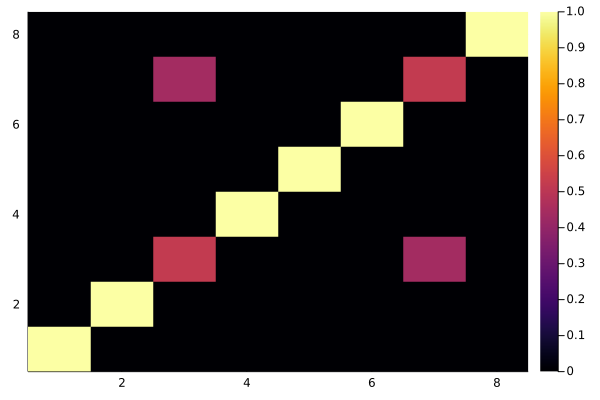

In [19]:
heatmap(abs.(S'S))

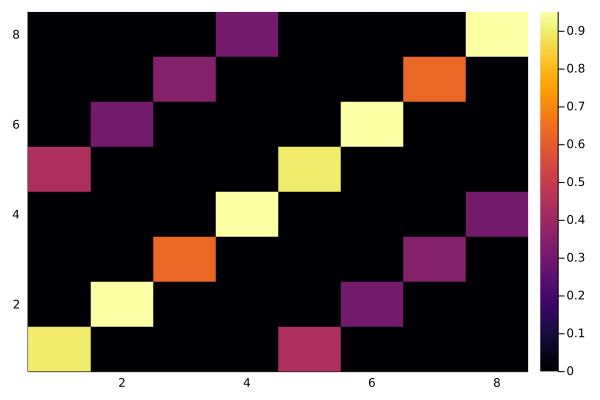

In [20]:
heatmap(abs.(S))

In [21]:
#### apply S matrix
u_out = S*[uy_p ; uy_n]
uy_p = u_out[1:Int(length(u_out)/2)]
uy_n = u_out[Int(length(u_out)/2)+1:Int(length(u_out))]


LoadError: [91mUndefVarError: uy_p not defined[39m

In [22]:
#### right after boundary
E_outp = ifft(uy_p)
E_outn = ifft(uy_n)

# plot(xvec, abs.(E_outp))
# plot!(xvec, abs.(E_outn))

plot(nvec, abs.(uy_p))
plot!(nvec, abs.(uy_n))


LoadError: [91mUndefVarError: uy_p not defined[39m

In [23]:
#### check conservation of energy
abs(dot(conj(E_in_p), E_in_p))
abs(dot(conj(E_in_n), E_in_n))

abs(dot(conj(E_outp), E_outp))
abs(dot(conj(E_outn), E_outn))

LoadError: [91mUndefVarError: E_outp not defined[39m

In [24]:
#### propagate through second layer
# u_y_p = @. u_y_p * exp(1im * b1 * d1)
# u_y_n = @. u_y_n * exp(-1im * b2 * d2)

println(u_y_p)
println(u_y_n)

E_outp = ifft(u_y_p)
E_outn = ifft(u_y_n)
plot(xvec, abs.(E_outp))
# plot(xvec, abs.(E_outn))

LoadError: [91mUndefVarError: u_y_p not defined[39m

In [25]:
#### OLD Not Needed Anymore OLD ####

Nx = 10 # number of discretized points in x

h = L/Nx
rows = vcat([[i, i, i] for i=1:Nx]...)
cols = vcat(vcat([[1,2,3]], [[i-1, i, i+1] for i=2:Nx-1], [Nx.-[2,1,0]])...)
vals = repeat([1,-2,1]./h^2, Nx)
A = sparse(rows, cols, vals, Nx, Nx) + w0^2*e1*I

vals, vecs = eigs(Array(A))

print(vals)
# print(vecs)

LoadError: [91mUndefVarError: w0 not defined[39m

In [26]:
#### trying to debug (5/19/21)
nvec = 0:3
ϵ = repeat([1], length(nvec))
μ = repeat([1], length(nvec))

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λ = 0.75
ω₀ = 2*pi/λ
k = ω₀
# nvec = 0:length(M)^0.5-1 # 100 modes
kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L) 
β = @. sqrt(Complex(ω₀^2 - kₓ^2))
# display(β)

M = 1im*(k*Matrix(Diagonal(ϵ)))/2
N = 1im*2/k*Matrix(Diagonal(1 ./μ))

A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
    -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
    -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
S = A\B

u_in = [u_p; u_n]
u_out = S*u_in
display(u_in)
display(u_out)
println("reflection: ", abs(u_out[1])^2)
println("transmission: ", abs(u_out[5])^2)
println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2)

8-element Array{Int64,1}:
 1
 0
 0
 0
 0
 0
 0
 0

8-element Array{Complex{Float64},1}:
 -4.163336342344337e-17 - 0.45171988308443356im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im
     -0.892159821571329 - 2.7755575615628914e-17im
                    0.0 + 0.0im
                    0.0 + 0.0im
                    0.0 + 0.0im

reflection: 0.20405085277381432
transmission: 0.7959491472261856
energy: 0.9999999999999999


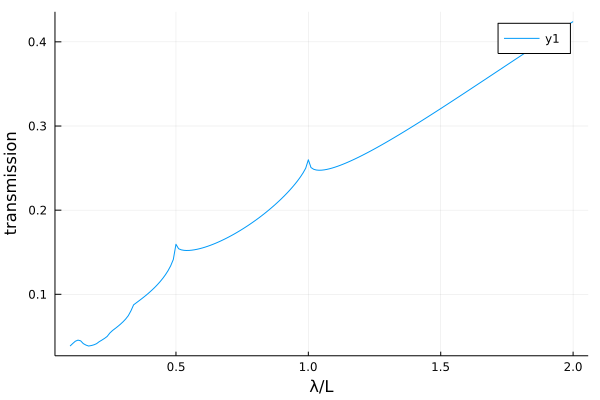

In [27]:
#### 5/19/21
nvec = 0:99
# ϵ = repeat([1e-9], length(nvec)) ## susceptibility
μ = repeat([1e-9], length(nvec))
ϵ = [(n > 40 && n < 60) ? 1e-9 : 1 for n in nvec]
# μ = [(n > 48 && n < 52) ? 1e-9 : 1 for n in nvec]

u_p = [n == 0 ? 1 : 0 for n in nvec]
u_n = [n == 0 ? 0 : 0 for n in nvec]

# S, β = get_all_modes(M, N, 1, 0.5)
L = 1
λᵥ = 0.1:0.01:2
T = zeros(0)
for λ in λᵥ
    ω₀ = 2*pi/λ
    k = ω₀
    kₓ = 2*pi*fftfreq(length(nvec), length(nvec)/L)
    β = @. sqrt(Complex(ω₀^2 - kₓ^2))
    # display(β)

    M = 1im*(k*Matrix(Diagonal(ϵ)))/2
    N = 1im*2/k*Matrix(Diagonal(1 ./μ))

    A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
        -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
    B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
        -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
    S = A\B
    # display(S)

    u_in = [u_p; u_n]
    u_out = S*u_in
    # display(u_in)
    # display(u_out)
#     println("reflection: ", abs(u_out[1])^2)
#     println("transmission: ", abs(u_out[5])^2)
#     println("energy: ", abs(u_out[1])^2 + abs(u_out[5])^2, "\n")
    append!(T, abs(u_out[101])^2)
end
plot(λᵥ, T, xlabel="λ/L", ylabel="transmission")

# Checking with Carlos's Solver

100-element Array{Complex{Float64},1}:
  1.6651049807144785e-17 + 1.4712690144369643e-17im
  1.8877265134225978e-17 + 1.4861123261039202e-17im
  3.3594529881315333e-17 + 4.295983224681567e-17im
   2.736592765728106e-17 - 4.80512131858171e-17im
   4.563092480750172e-19 - 4.05620745514324e-17im
 -1.8978390477358188e-17 - 2.2856491752936357e-17im
 -2.0545830971103047e-17 - 1.5827468094796216e-17im
  -4.997181209737893e-18 - 1.5874054335785367e-17im
  -3.655950405628373e-18 - 1.0013080028107408e-17im
  -7.204831715633814e-18 - 1.1054012272461644e-17im
   -8.75294001271254e-18 - 7.743010491347159e-18im
  -1.144201308954251e-17 - 9.420572989548892e-18im
  -7.160733944234516e-18 - 7.725268130686377e-18im
                         ⋮
   0.0014909097366170758 + 6.533945518311782e-5im
  1.9727200532378252e-17 + 1.648081309584926e-18im
  1.9788896303770758e-17 - 7.392448228109616e-18im
  2.4553267415855772e-17 + 1.0591463475313949e-17im
    -0.03582036907076812 + 0.013311419499130981im
  1.57512561

100-element Array{Complex{Float64},1}:
  1.1849439887353475e-17 - 9.98908873134472e-18im
  -1.950463258330514e-17 + 1.6547493496802526e-17im
   5.035943580591313e-18 + 7.661588695673141e-18im
   7.906929887982774e-18 - 7.857688787723675e-18im
 -2.8252577290750397e-19 - 2.8681061535225545e-17im
  -8.770511576186784e-18 + 3.489553225730936e-18im
  -6.384785692455675e-18 - 2.968965185472476e-18im
   8.418851111782051e-18 - 1.31643483887516e-18im
 -1.4636433638934128e-18 + 8.110907916841969e-18im
 -5.9124803789680975e-18 + 1.2406946688598892e-18im
   -2.22734232985245e-19 - 4.594071941410885e-18im
  -9.500452567329735e-19 + 3.103485377043781e-18im
 -1.0365680281144449e-18 - 1.4814826387997381e-18im
                         ⋮
   1.860671090812713e-18 + 6.171365578736027e-18im
 -6.2155330666503354e-18 + 6.822508819275087e-18im
   -0.001134657347303143 - 0.008194274023625932im
  -1.545600413465372e-17 - 5.6389954557114e-18im
  -3.954242793464798e-17 + 2.846967659080405e-18im
  -7.359819117020

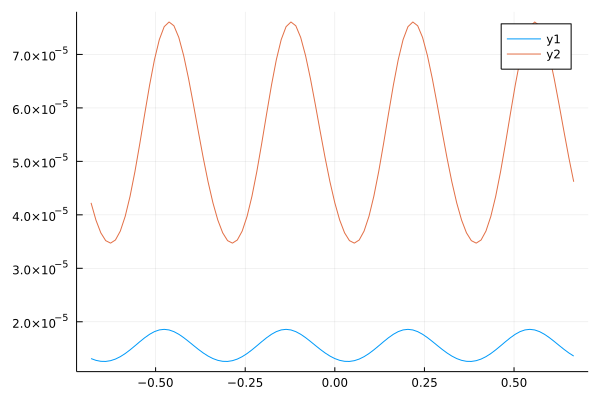

In [28]:
#### Matching Carlos's solver
k = 10.0;
λ = 2*pi/k;
θ = -π/2.0; # incidence angle (measured with respect to the x axis)
α = k*cos(θ);
β = k*sin(θ);
uInc(x,y)= @. exp(1im*α*x+1im*β*y);  # incident planewave

θᵗ = -π/8;    # transmitted field angle
d  = cos(θᵗ)-cos(θ); 
L = 2*(2*π)/(k*abs(d));  # Unit cell width
M₀(x) = @. -sin(θ)*(1+exp(1im*k*d*x));
N₀(x) = @. -sin(θ)*(1-exp(1im*k*d*x));

nvec = 0:99;
dx = L/length(nvec)
xvec = [n*dx-L/2 for n in nvec]
kₓ = 2*pi*fftfreq(length(nvec), 1/dx)
β = @. sqrt(Complex(k^2 - kₓ^2))

u_p = fft(uInc(xvec, 0))/length(nvec)
u_n = zeros(length(nvec))
M = Matrix(Diagonal(M₀(xvec)))
N = Matrix(Diagonal(N₀(xvec)))
# display(N)


A = [-Diagonal(β)-k*ifft(fft(M, 2), 1)    -Diagonal(β)-k*ifft(fft(M, 2), 1);
    -Diagonal(β)-k*ifft(fft(N, 2), 1)     Diagonal(β)+k*ifft(fft(N, 2), 1)]
B = [-Diagonal(β)+k*ifft(fft(M, 2), 1)    -Diagonal(β)+k*ifft(fft(M, 2), 1);
    -Diagonal(β)+k*ifft(fft(N, 2), 1)     Diagonal(β)-k*ifft(fft(N, 2), 1)]
S = A\B
# display(S)

u_in = [u_p; u_n]
u_out = S*u_in
u_out_p = u_out[1:length(nvec)]
u_out_n = u_out[length(nvec)+1:2*length(nvec)]
display(u_out_p)
display(u_out_n)
plot(xvec, abs2.(ifft(u_out_p)))
plot!(xvec, abs2.(ifft(u_out_n)))

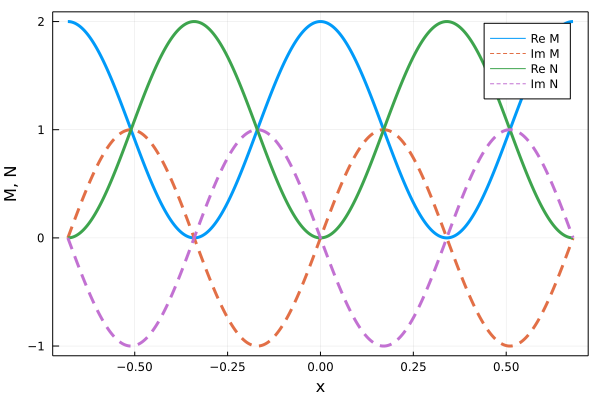

In [29]:
xPlot = -L/2:0.001:L/2;

paramPlot = plot(xPlot,real.(M₀.(xPlot)))

paramPlot = plot!(xPlot,imag.(M₀.(xPlot))) 

paramPlot = plot!(xPlot,real.(N₀.(xPlot))) 

paramPlot = plot!(xPlot,imag.(N₀.(xPlot))) 

plot(paramPlot,lw=3,linestyle=[:solid :dash :solid :dash],label = ["Re M" "Im M" "Re N" "Im N"],frame=:box)
xlabel!("x");ylabel!("M, N")

In [30]:
E1(x,z) = sum([u_out_p[n+1]*exp(-1im*kₓ[n+1]*x)*exp(1im*β[n+1]*z) for n in nvec])+sum([u_p[n+1]*exp(-1im*kₓ[n+1]*x)*exp(1im*β[n+1]*z) for n in nvec])
E2(x,z) = sum([u_out_n[n+1]*exp(-1im*kₓ[n+1]*x)*exp(-1im*β[n+1]*z) for n in nvec])

xview = -L:0.02:L 
zview = 0:0.01:L
zview2 = -L:0.01:0
Emat = zeros(Complex{Float64}, 0)
Emat2 = zeros(Complex{Float64}, 0)
for (z1, z2) in zip(zview, zview2)
    append!(Emat, E1.(xview, z1))
    append!(Emat2, E2.(xview, z2))
end
Emat = reshape(Emat,length(xview),:)
Emat2 = reshape(Emat2,length(xview),:)
# display(Emat)
# display(Emat2)


137×137 Array{Complex{Float64},2}:
  -0.342139+0.637185im    -0.317511+0.649808im    …   -0.641596+0.10522im
  -0.453383+0.563478im    -0.431493+0.580412im        -0.694645+0.00105582im
  -0.549191+0.470588im    -0.530784+0.491255im         -0.73096-0.135976im
  -0.626301+0.361677im    -0.612005+0.385374im        -0.731259-0.302069im
   -0.68209+0.240452im    -0.672391+0.266372im        -0.677898-0.482247im
  -0.714656+0.111041im    -0.709885+0.138302im    …   -0.561882-0.651285im
  -0.722892-0.02215im      -0.72321+0.00552332im      -0.389147-0.779714im
  -0.706517-0.154587im    -0.711914-0.127443im        -0.181956-0.843901im
  -0.666089-0.281762im    -0.676381-0.256071im        0.0271448-0.8357im
  -0.602983-0.399343im     -0.61782-0.375981im         0.206897-0.76597im
  -0.519349-0.503329im    -0.538226-0.483091im    …    0.338457-0.659484im
  -0.418034-0.590179im    -0.440307-0.573754im         0.420125-0.544193im
  -0.302486-0.656937im    -0.327398-0.644883im         0.464159-0.4

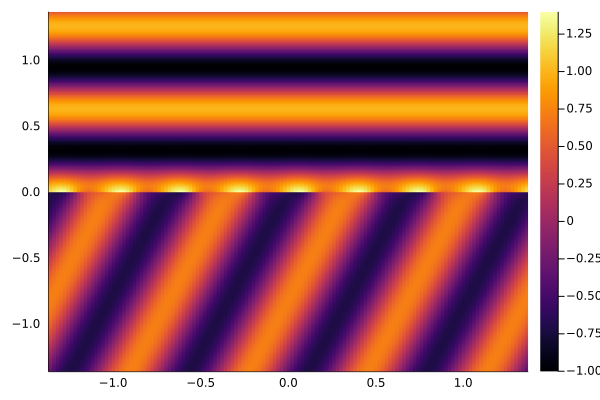

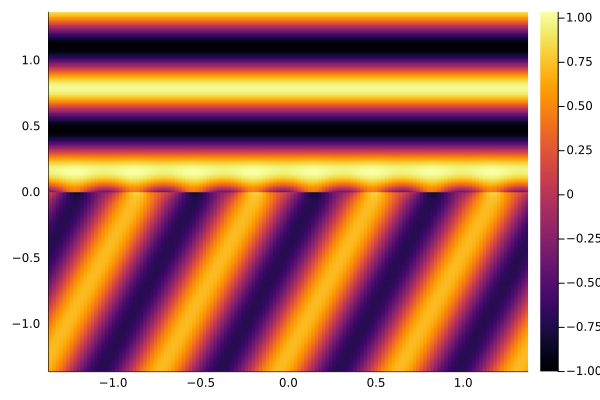

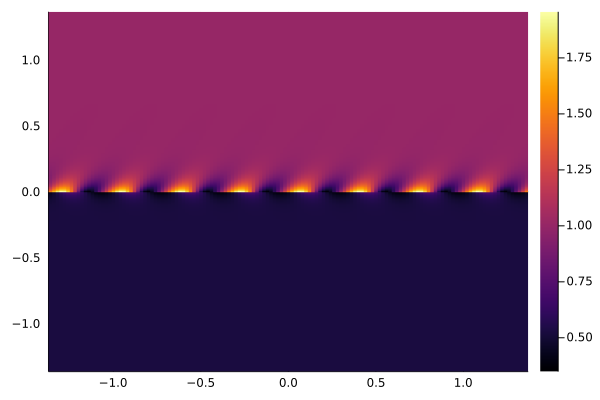

In [31]:
plt1 = heatmap(xview, zview2, transpose(real.(Emat2)))
plt1 = heatmap!(xview, zview, transpose(real.(Emat)))
display(plt1)
plt2 = heatmap(xview, zview2, transpose(imag.(Emat2)))
plt2 = heatmap!(xview, zview, transpose(imag.(Emat)))
display(plt2)
plt3 = heatmap(xview, zview2, transpose(abs2.(Emat2)))
plt3 = heatmap!(xview, zview, transpose(abs2.(Emat)))
display(plt3)